### Data Cleaning + Analysis Notebook 2

***NOTE***: 

- Datsets Aquired from PolicyMap / Census: Decennial Census and American Community Survey (ACS)

- Merging Insured, Uninsured, and Estimated Population datasets, handling missing values, aligning variable definitions across data sources, and performing initial exploratory analysis to verify data consistency and identify early trends.

In [1]:
import pandas as pd

# Load insured data
insured = pd.read_csv(
    "Data_Files_Uncleaned/Insured_By_County_2019_2023_US.csv",
)

# Keep and rename relevant columns
insured = insured[["Geography Name", "Sits in State", "GeoID", "People With Health Insurance"]]
insured = insured.rename(columns={
    "Geography Name": "County",
    "Sits in State": "State",
    "GeoID": "GeoID",
    "People With Health Insurance": "Insured"
})


In [2]:
# Load uninsured data
uninsured = pd.read_csv(
    "Data_Files_Uncleaned/Uninsured_By_County_2019_2023_US.csv",
)

# Keep and rename relevant columns
uninsured = uninsured[["Geography Name", "Sits in State", "GeoID", "People Without Health Insurance"]]
uninsured = uninsured.rename(columns={
    "Geography Name": "County",
    "Sits in State": "State",
    "GeoID": "GeoID",
    "People Without Health Insurance": "Uninsured"
})


In [3]:
# Load population data
population = pd.read_csv(
    "Data_Files_Uncleaned/Estimated_Population_2019_2023.csv"
)

# Keep and rename relevant columns
population = population[[
    "Geography Name",
    "Sits in State",
    "GeoID",
    "Population"
]].rename(columns={
    "Geography Name": "County",
    "Sits in State": "State",
    "GeoID": "GeoID",
    "Population": "Total_Population"
})


In [4]:
# Merge datasets
insurance_merged = (
    insured
    .merge(uninsured, on=["County", "State", "GeoID"], how="inner")
    .merge(population, on=["County", "State", "GeoID"], how="inner")
)


In [5]:
# Convert columns to numeric
numeric_cols = ["Insured", "Uninsured", "Total_Population"]
insurance_merged[numeric_cols] = insurance_merged[numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)


In [6]:
# Calculate percentages
insurance_merged["Percent_Insured"] = (
    insurance_merged["Insured"] / insurance_merged["Total_Population"] * 100
)
insurance_merged["Percent_Uninsured"] = (
    insurance_merged["Uninsured"] / insurance_merged["Total_Population"] * 100
)


In [7]:
# Drop any rows missing key data
insurance_merged = insurance_merged.dropna(subset=["Total_Population", "Insured", "Uninsured"])

# Reorder columns for clarity
insurance_merged = insurance_merged[[
    "County",
    "State",
    "GeoID",
    "Total_Population",
    "Insured",
    "Uninsured",
    "Percent_Insured",
    "Percent_Uninsured"
]]


In [8]:
# Preview cleaned dataset
insurance_merged.head()


,County,State,GeoID,Total_Population,Insured,Uninsured,Percent_Insured,Percent_Uninsured
0,Autauga,AL,1001,59285.0,53685.0,4268.0,90.554103,7.199123
1,Baldwin,AL,1003,239945.0,217366.0,19338.0,90.589927,8.059347
2,Barbour,AL,1005,24757.0,19335.0,2350.0,78.099123,9.492265
3,Bibb,AL,1007,22152.0,19051.0,1730.0,86.001264,7.809679
4,Blount,AL,1009,59292.0,52832.0,5997.0,89.104770,10.114349


In [9]:
# Save cleaned dataset
insurance_merged.to_csv("insurance_and_population_merged_2019_2023_us_cleaned.csv", index=False)

print("Cleaned dataset saved as 'insurance_and_population_merged_2019_2023_us_cleaned.csv'")


Cleaned dataset saved as 'insurance_and_population_merged_2019_2023_us_cleaned.csv'


***Data Analysis (validating data integrity)***: 

- Conducting Data Analysis below to determine if we gain meaningful insights from the data

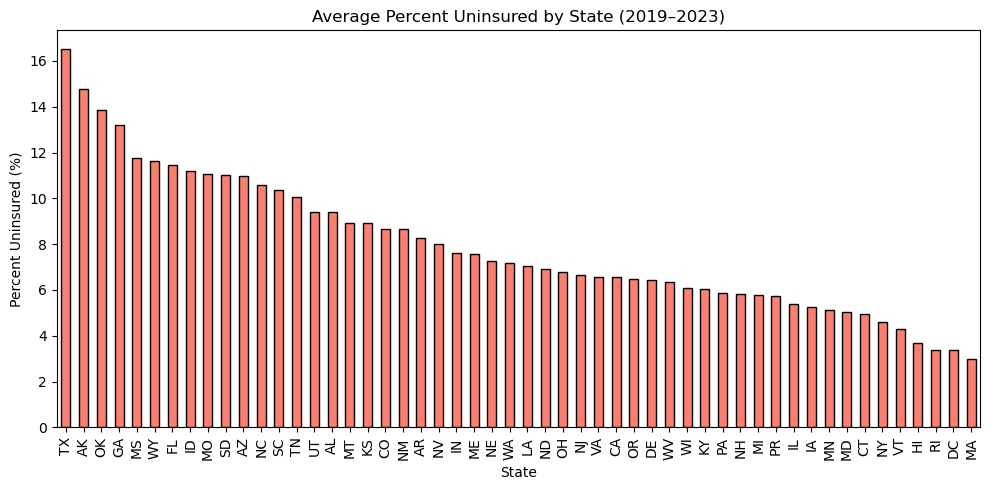

In [10]:
import matplotlib.pyplot as plt

# Distribution of uninsured rates by state
state_uninsured = insurance_merged.groupby("State")["Percent_Uninsured"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
state_uninsured.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Average Percent Uninsured by State (2019–2023)")
plt.ylabel("Percent Uninsured (%)")
plt.xlabel("State")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



***Data Analysis (distribution of uninsured rates by state)***: 

- Note that the data used here ranged from 2019 to 2023 (latest data available by PolicyMap / Census)
  
- Texas seems to have the highest average percent of uninsured residents in the US, probably due to several factors such as the state's refusal to expand Medicaid, economic barriers, and a large population of low-wage workers. 

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Group by state
state_insurance = insurance_merged.groupby("State", as_index=False)[["Percent_Insured", "Percent_Uninsured"]].mean()

# Create side-by-side maps
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Percent Insured by State", "Percent Uninsured by State"),
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]]
)

# Left map — Insured
fig.add_trace(
    go.Choropleth(
        locations=state_insurance["State"],
        z=state_insurance["Percent_Insured"],
        locationmode="USA-states",
        colorscale="Greens",
        showscale=False,
    ),
    row=1, col=1
)

# Right map — Uninsured
fig.add_trace(
    go.Choropleth(
        locations=state_insurance["State"],
        z=state_insurance["Percent_Uninsured"],
        locationmode="USA-states",
        colorscale="Reds",
        showscale=False,  
    ),
    row=1, col=2
)

# Layout — keep both maps consistent
fig.update_layout(
    title_text="Health Insurance Coverage Across U.S. States (2019–2023)",
    title_x=0.5,
    geo_scope="usa",
    geo=dict(
        scope="usa",
        projection_type="albers usa",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)"
    ),
    geo2=dict(
        scope="usa",
        projection_type="albers usa",
        showlakes=True,
        lakecolor="rgb(255, 255, 255)"
    ),
    height=500,
    width=1100,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


***NOTE***: 

Percent Insured by State: 
- Green = States where there is a higher percentage of residents that are insured
  
- Light Green = States where there is a lower percentage of residents that are insured

Percent Uninsured by State: 
- Light red = States where there is a lower percentage of residents that are uninsured
  
- Red = States where there is a higher percentage of residents that are uninsured
  
